### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,5
sb.set_style(style='darkgrid')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Producing user-genre matrix, that indicates how much each user likes a genre.

In [2]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
m_g_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation'
           , 'Children', 'Comedy','Crime', 'Documentary', 'Drama', 'Fantasy'
           , 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


data_set_path_users = "InputData/ml-100k/u.user"
data_set_path_ratings = "InputData/ml-100k/u.data"
data_set_path_movies = "InputData/ml-100k/u.item"
users = pd.read_csv(data_set_path_users,sep='|',names = u_cols)
ratings = pd.read_csv(data_set_path_ratings,sep='\t', names = r_cols).drop('timestamp',axis=1)
movies = pd.read_csv(data_set_path_movies, sep='|', names = m_cols, usecols=range(5))
movies_genre_df = pd.read_csv(data_set_path_movies, sep='|', names = m_g_cols).drop(['title', 'release_date', 'video_release_date', 'imdb_url'],axis=1)

### Users Demographic

In [3]:
# Load the user demographic data
user_data = pd.read_csv(data_set_path_users, sep='|', names=['user_id', 'age', 'sex', 'occupation', 'zip_code'], engine='python')

# Encode gender: 0 for male (M), 1 for female (F)
user_data['gender_encoded'] = user_data['sex'].apply(lambda x: 0 if x == 'M' else 1)
user_data.head(2)

,user_id,age,sex,occupation,zip_code,gender_encoded
0,1,24,M,technician,85711,0
1,2,53,F,other,94043,1


### DataSource Preparation

In [4]:
# cleaning the unknown items(movie) from our data - when we have the features of the items we can wok on it
# wherein our focosed feature is the genre of the movie so we find the movies with unknow genre and remove it from our dfs
movie_ids_to_be_removed = list(movies_genre_df[movies_genre_df['unknown'] == 1]['movie_id'])
for ids in movie_ids_to_be_removed:
    ratings.drop((ratings[ratings['movie_id'] == ids]).index, inplace=True)
    movies.drop((movies[movies['movie_id'] == ids]).index, inplace=True)
    movies_genre_df.drop((movies_genre_df[movies_genre_df['movie_id'] == ids]).index, inplace=True)  
# To Test run the code below
ratings.iloc[ratings[ratings['movie_id'] == ids].index]

,user_id,movie_id,rating


### Emplifying ratings by genres
Depicting the interest of each user for each genre

In [5]:
# G : Movie-Genre Matrix
# R : User-Movie Matrix
# UG: User-Genre Matrix
G = np.array(movies_genre_df.drop(['movie_id','unknown'],axis=1))
R = np.array(pd.read_csv('InputData/R.csv').loc[:,'1':'1682'],dtype='float')
UG = np.dot(R,G)
UG.shape

(943, 18)

In [6]:
# Selecting features for clustering
X = np.hstack((UG,np.array(user_data[['age', 'gender_encoded']])))
X.shape

(943, 20)

### Normalize the features

In [7]:
# Initialize the scaler
scaler = MinMaxScaler()
#scaler = StandardScaler()   # standard normally distributed data (e.g., Gaussian with 0 mean and unit variance)

X_scaled = scaler.fit_transform(X)
# pd.DataFrame(X_scaled).to_csv('X_scaled_minmax.csv')
X_scaled

array([[0.4789272 , 0.45220588, 0.38095238, ..., 0.30985915, 0.25757576,
        0.        ],
       [0.07279693, 0.04779412, 0.03809524, ..., 0.        , 0.6969697 ,
        1.        ],
       [0.07471264, 0.05147059, 0.        , ..., 0.        , 0.24242424,
        0.        ],
       ...,
       [0.07279693, 0.09926471, 0.13333333, ..., 0.        , 0.1969697 ,
        0.        ],
       [0.14176245, 0.19117647, 0.18095238, ..., 0.1971831 , 0.62121212,
        1.        ],
       [0.4348659 , 0.41911765, 0.06666667, ..., 0.32394366, 0.22727273,
        0.        ]])

e:\Users\Milad\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


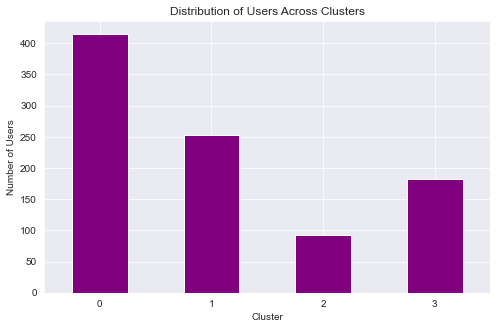

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender_encoded
UserType1,44.869880,21.966265,4.493976,8.098795,44.426506,16.985542,1.412048,76.831325,1.445783,3.561446,7.978313,5.257831,12.402410,35.016867,23.498795,43.672289,19.653012,1.903614,35.161446,-3.330669e-16
UserType2,55.948617,31.549407,9.845850,20.739130,78.505929,19.624506,1.881423,121.288538,3.118577,4.241107,11.624506,14.059289,14.715415,64.628458,27.454545,55.162055,25.418972,3.450593,34.011858,1.000000e+00
UserType3,280.483871,161.075269,48.397849,94.000000,352.408602,87.268817,9.741935,451.483871,17.473118,22.935484,64.569892,68.473118,52.913978,210.580645,138.193548,227.086022,102.795699,28.677419,33.032258,2.150538e-01
UserType4,165.906593,88.494505,22.181319,36.994505,165.818681,50.153846,4.483516,233.785714,7.324176,11.604396,28.780220,29.329670,29.071429,109.972527,86.692308,129.395604,64.362637,13.016484,32.098901,-1.665335e-16


In [8]:
# Apply K-Means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
user_data['cluster'] = kmeans.fit_predict(X_scaled)

# Check the distribution of users across the clusters
cluster_distribution = user_data['cluster'].value_counts().sort_index()

# Visualize the distribution of users across clusters
plt.figure(figsize=(8, 5))
cluster_distribution.plot(kind='bar', color='purple')
plt.title('Distribution of Users Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()

# Let's also explore the centroids to understand the clusters better
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), index=['UserType1', 'UserType2', 'UserType3', 'UserType4'], columns=['Action', 'Adventure', 'Animation'
           , 'Children', 'Comedy','Crime', 'Documentary', 'Drama', 'Fantasy'
           , 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western','age', 'gender_encoded'])
# centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_))
centroids

In [9]:
user_data['cluster'].value_counts()

0    415
1    253
3    182
2     93
Name: cluster, dtype: int64

In [10]:
user_data['user_id'] = user_data['user_id']-1

In [11]:
user_data[user_data['cluster'] == 3]

,user_id,age,sex,occupation,zip_code,gender_encoded,cluster
0,0,24,M,technician,85711,0,3
5,5,42,M,executive,98101,0,3
9,9,53,M,lawyer,90703,0,3
15,15,21,M,entertainment,10309,0,3
20,20,26,M,writer,30068,0,3
...,...,...,...,...,...,...,...
918,918,25,M,other,14216,0,3
926,926,23,M,programmer,55428,0,3
932,932,28,M,student,48105,0,3
933,933,61,M,engineer,22902,0,3


In [12]:
user_indices_of_Type =[]
for t in range(kmeans.n_clusters):
    user_indices_of_Type.append(list(user_data[user_data['cluster'] == t]['user_id']))

In [13]:
%store user_indices_of_Type

Stored 'user_indices_of_Type' (list)


In [14]:
W_clustered = centroids.transpose()
W_clustered

,UserType1,UserType2,UserType3,UserType4
Action,4.486988e+01,55.948617,280.483871,1.659066e+02
Adventure,2.196627e+01,31.549407,161.075269,8.849451e+01
Animation,4.493976e+00,9.845850,48.397849,2.218132e+01
Children,8.098795e+00,20.739130,94.000000,3.699451e+01
Comedy,4.442651e+01,78.505929,352.408602,1.658187e+02
Crime,1.698554e+01,19.624506,87.268817,5.015385e+01
Documentary,1.412048e+00,1.881423,9.741935,4.483516e+00
Drama,7.683133e+01,121.288538,451.483871,2.337857e+02
Fantasy,1.445783e+00,3.118577,17.473118,7.324176e+00
Film-Noir,3.561446e+00,4.241107,22.935484,1.160440e+01


In [15]:
from sklearn.preprocessing import normalize

# Normalize the matrix so that each row has a unit sum
W_clustered_normal = normalize(W_clustered, axis=1, norm='l1')

pd.DataFrame(W_clustered_normal[:-2]).to_csv('W_clustered_normal.csv')

In [16]:
W_clustered_normal

array([[ 8.19977061e-02,  1.02243605e-01,  5.12571780e-01,
         3.03186909e-01],
       [ 7.24754861e-02,  1.04094101e-01,  5.31451677e-01,
         2.91978736e-01],
       [ 5.29207389e-02,  1.15944023e-01,  5.69929615e-01,
         2.61205623e-01],
       [ 5.06705374e-02,  1.29755459e-01,  5.88115937e-01,
         2.31458067e-01],
       [ 6.92908565e-02,  1.22443639e-01,  5.49642456e-01,
         2.58623049e-01],
       [ 9.75997100e-02,  1.12763318e-01,  5.01450655e-01,
         2.88186317e-01],
       [ 8.06013124e-02,  1.07393754e-01,  5.56080727e-01,
         2.55924206e-01],
       [ 8.69733338e-02,  1.37299056e-01,  5.11081349e-01,
         2.64646261e-01],
       [ 4.92405202e-02,  1.06212581e-01,  5.95099925e-01,
         2.49446974e-01],
       [ 8.41105628e-02,  1.00162096e-01,  5.41666664e-01,
         2.74060678e-01],
       [ 7.06339636e-02,  1.02914602e-01,  5.71653092e-01,
         2.54798343e-01],
       [ 4.48927206e-02,  1.20041833e-01,  5.84641153e-01,
      

In [34]:
W_clustered_normal[:-2]

array([[0.08199771, 0.1022436 , 0.51257178, 0.30318691],
       [0.07247549, 0.1040941 , 0.53145168, 0.29197874],
       [0.05292074, 0.11594402, 0.56992961, 0.26120562],
       [0.05067054, 0.12975546, 0.58811594, 0.23145807],
       [0.06929086, 0.12244364, 0.54964246, 0.25862305],
       [0.09759971, 0.11276332, 0.50145066, 0.28818632],
       [0.08060131, 0.10739375, 0.55608073, 0.25592421],
       [0.08697333, 0.13729906, 0.51108135, 0.26464626],
       [0.04924052, 0.10621258, 0.59509993, 0.24944697],
       [0.08411056, 0.1001621 , 0.54166666, 0.27406068],
       [0.07063396, 0.1029146 , 0.57165309, 0.25479834],
       [0.04489272, 0.12004183, 0.58464115, 0.25042429],
       [0.11367591, 0.13487607, 0.48499002, 0.266458  ],
       [0.08333411, 0.15380459, 0.50114564, 0.26171566],
       [0.0851902 , 0.09953098, 0.50099315, 0.31428567],
       [0.09591644, 0.12115115, 0.49874381, 0.28418859],
       [0.09260228, 0.11977069, 0.48435916, 0.30326787],
       [0.04046102, 0.0733418 ,

(array([  8., 101., 197., 221., 123., 115., 111.,  36.,  23.,   8.]),
 array([ 7. , 13.6, 20.2, 26.8, 33.4, 40. , 46.6, 53.2, 59.8, 66.4, 73. ]),
 <BarContainer object of 10 artists>)

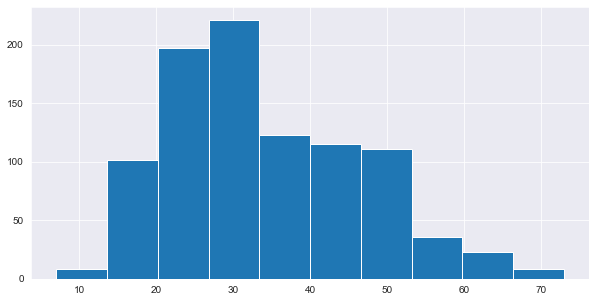

In [13]:
plt.hist(users["age"])

(array([670.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 273.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

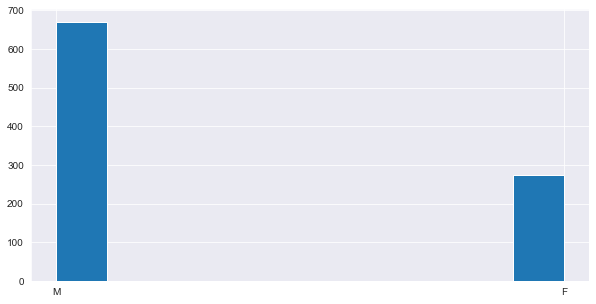

In [11]:
plt.hist(users['sex'])

In [5]:
users.sort_values(by='age')

,user_id,age,sex,occupation,zip_code
29,30,7,M,student,55436
470,471,10,M,student,77459
288,289,11,M,none,94619
879,880,13,M,student,83702
608,609,13,F,student,55106
...,...,...,...,...,...
584,585,69,M,librarian,98501
766,767,70,M,engineer,00000
802,803,70,M,administrator,78212
859,860,70,F,retired,48322


In [6]:
users[users['user_id'] == 1]

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711


In [7]:
ratings.sort_values('user_id')
ratings[ratings['user_id'] == 1].sort_values('rating',ascending=False)

,user_id,movie_id,rating
19996,1,170,5
7561,1,175,5
36844,1,119,5
38193,1,181,5
40519,1,109,5
...,...,...,...
3248,1,74,1
6649,1,78,1
39865,1,131,1
8745,1,259,1


In [8]:
movies[movies['movie_id'] == 8]

,movie_id,title,release_date,video_release_date,imdb_url
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995)


In [9]:
movies_genre_df[movies_genre_df['movie_id'] == 170]

,movie_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
169,170,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0


In [13]:
movies_genre_df.sum()

movie_id       1415403
unknown              2
Action             251
Adventure          135
Animation           42
Children           122
Comedy             505
Crime              109
Documentary         50
Drama              725
Fantasy             22
Film-Noir           24
Horror              92
Musical             56
Mystery             61
Romance            247
Sci-Fi             101
Thriller           251
War                 71
Western             27
dtype: int64